# Analyze best MNCs
Required to run `gen_mnc_samples.py` and `eval_mnc_samples.py` before this script.
For example,

~~~~
erol$ python gen_mnc_samples.py -f input_dir -s 100 -o mnc_ensemble_0 --testsize 0.90
erol$ python eval_mnc_samples.py -f mnc_ensemble_0
erol$ python eval_mnc_samples.py -f mnc_ensemble_0 --testset
~~~~

Analysis of inferred MNCs

1. General assessment 
2. MNC objectives
3. GWAS of MNC flux states
4. Pathway enrichments
5.

In [1]:
from mnc_utils import *

import pandas as pd
import cobrascape.ensemble as ens
from tqdm import tqdm
import seaborn as sns
from adjustText import adjust_text
%matplotlib inline
import matplotlib.pyplot as plt
import os
from matplotlib import cm
import numpy as np

from os import listdir, path
from cobrascape.species import save_json_obj, load_json_obj

In [2]:
ENSEMBLE_DIR = "mnc_ensemble_0"

In [3]:
ENSEMBLE_MAP_ASSESS = ENSEMBLE_DIR+"/popfva_assessment/"

ensemble_args_dict = load_json_obj(ENSEMBLE_DIR+"/mnc_ensemble_args.json")
action_num = ensemble_args_dict["action_num"] # 4 
ADD_NA_BOUND = ensemble_args_dict["nabound"] # False
STANDARDIZE_ = ensemble_args_dict["popFVA_STANDARDIZE"] # False
print("action_num (%d), nabound (%s), standardize (%s)"%(action_num, str(ADD_NA_BOUND),str(STANDARDIZE_)))

print("...loading TRAINING data...")
X_species_final = pd.read_csv(ENSEMBLE_DIR+"/X_train.csv", index_col = 0)
Y_pheno_final = pd.read_csv(ENSEMBLE_DIR+"/y_train.csv", index_col = 0)

if not os.path.exists(ENSEMBLE_DIR+"/figures"):
    print('\t... creating figures directory for saving MNC analysis plots:'+ENSEMBLE_DIR+"/figures/")
    os.makedirs(ENSEMBLE_DIR+"/figures/")

pheno_to_data2d_dict = {}
pheno_to_Y_dict = {}
pheno_list = Y_pheno_final.columns
ALLELE_PHENO_FILE = ENSEMBLE_DIR+"/allele_pheno_data"
for pheno_id in pheno_list:
    G_VARIANT_MATRIX_FILE = ALLELE_PHENO_FILE+"/allele_df_"+pheno_id+".csv"
    PHENO_MATRIX_FILE = ALLELE_PHENO_FILE+"/pheno_df_"+pheno_id+".csv"
    pheno_to_data2d_dict.update({pheno_id: pd.read_csv(G_VARIANT_MATRIX_FILE,index_col=0)})
    pheno_to_Y_dict.update({pheno_id: pd.read_csv(PHENO_MATRIX_FILE,index_col=0)[pheno_id]})## series

action_num (4), nabound (False), standardize (False)
...loading TRAINING data...


In [4]:
def load_samples_assess_df(ENSEMBLE_MAP_ASSESS, pheno_list):
    ### -------------- LOAD 2 -----------------
    print("(2) load SAMPLES_ASSESS_DF ...")
    onlyfiles = [f for f in listdir(ENSEMBLE_MAP_ASSESS) if path.isfile(path.join(ENSEMBLE_MAP_ASSESS, f))]
    onlyfiles = [f for f in onlyfiles if f != ".DS_Store"]
    samplesAfter = [f for f in onlyfiles if "sample_" in f] 

    wanted_keys = []
    ### Options for what we want in SAMPLES_ASSESS_DF
    for pheno_id in pheno_list:
        wanted_keys.extend(["AIC_"+pheno_id, "BIC_"+pheno_id])

    SAMPLES_ASSESS_DF = {}
    for landscape_sample_name in tqdm(samplesAfter):
        landscape_sample_num = landscape_sample_name.split("_")[1]
        sample_id = "sampled_map_"+str(landscape_sample_num)
        landscape_assess_sample_file = ENSEMBLE_MAP_ASSESS+landscape_sample_name

        if path.exists(landscape_assess_sample_file):
            landscape_assess_sample = load_json_obj(landscape_assess_sample_file)
            SAMPLES_ASSESS_DF[sample_id] = {}
            SAMPLES_ASSESS_DF[sample_id].update(dict((k, landscape_assess_sample[k]) for k in wanted_keys if k in landscape_assess_sample))

    # transform to pandas dataframe
    SAMPLES_ASSESS_DF = pd.DataFrame.from_dict(SAMPLES_ASSESS_DF,orient="index")
    print("\t... SAMPLES_ASSESS_DF shape: (samples: %d, assess_cols: %d)" % (SAMPLES_ASSESS_DF.shape[0], SAMPLES_ASSESS_DF.shape[1]))
    return SAMPLES_ASSESS_DF

In [5]:
SAMPLES_ASSESS_DF = load_samples_assess_df(ENSEMBLE_MAP_ASSESS, pheno_list)

100%|██████████| 5/5 [00:00<00:00, 493.77it/s]

(2) load SAMPLES_ASSESS_DF ...
	... SAMPLES_ASSESS_DF shape: (samples: 5, assess_cols: 14)


In [6]:
SAMPLES_ASSESS_DF

,AIC_isoniazid,BIC_isoniazid,AIC_rifampicin,BIC_rifampicin,AIC_ethambutol,BIC_ethambutol,AIC_cycloserine,BIC_cycloserine,AIC_ethionamide,BIC_ethionamide,AIC_4-aminosalicylic_acid,BIC_4-aminosalicylic_acid,AIC_pyrazinamide,BIC_pyrazinamide
sampled_map_0,179.943731,246.613365,182.404057,246.043254,155.305215,219.057691,40.775341,57.182891,46.746952,75.427297,41.490439,58.280405,19.528193,24.527473
sampled_map_1,173.157630,227.705513,163.645515,221.223836,152.731745,207.790701,36.109715,49.782673,73.548633,96.492909,35.223171,50.486777,21.757961,27.590455
sampled_map_2,151.536390,209.114710,155.319576,212.897897,130.594901,185.653857,36.094430,49.767388,78.769346,107.449692,36.237835,54.554161,27.119836,34.618756
sampled_map_3,159.054665,222.693862,175.478987,242.148622,150.395656,217.045971,49.801304,68.943445,69.239003,97.919348,45.155896,66.524943,32.626817,40.958951
sampled_map_4,188.965238,252.604435,178.958169,236.536490,145.008500,200.067456,43.968787,61.743633,63.522138,94.114506,32.397439,46.134683,26.600959,34.099879


In [7]:
for pheno_id in pheno_list:
    top_models = SAMPLES_ASSESS_DF["BIC_"+pheno_id].copy()
    top_models.sort_values(inplace=True)
    top_models.to_csv(ENSEMBLE_DIR+"/tables/best_mncs_"+pheno_id+".csv",header=True)

In [8]:
### check 
top_models = pd.read_csv(ENSEMBLE_DIR+"/tables/best_mncs_"+pheno_id+".csv",index_col=0)
top_models

,BIC_pyrazinamide
sampled_map_0,24.527473
sampled_map_1,27.590455
sampled_map_4,34.099879
sampled_map_2,34.618756
sampled_map_3,40.958951


# `03a` - Analyze the MNC objective functions

1. Average the strain-specific flux states across the best MNCs and perform Flux GWAS

### 1. Load objectives from best MNCS and align them to all be maximizations. Then determine the median objective coefficient.
    - outputs: 
        - ENSEMBLE_DIR/allele_med_bnd-min_maptype-new_isoniazid.json
        - ENSEMBLE_DIR/allele_med_categoricalbnd-min_maptype-new_isoniazid.json
        
        
###  _OPTIONAL_: Average MNCs by performing bayesian model averaging, which weights MNC objectives according to their relative BIC value

In [9]:
def get_mnc_direction(pheno_id, sample_id, ENSEMBLE_DIR):
    """ Return whether the MNC optimization is a minimization or maximization
    """
    popdf_id = "pop_sol"
    obj_direct_pval_list = []
    for obj_direction in ["max", "min"]:
        found_file=False
        popsol_anova_loc = ENSEMBLE_DIR+"/tables/"+pheno_id+"_"+sample_id+"_OBJdirect-"+obj_direction+"_"+"pop_sol"+"_train.csv"
        if os.path.exists(popsol_anova_loc):
            popsol_anova_df = pd.read_csv(popsol_anova_loc, index_col=0)
        else:
            print("can't locate %s"%(popsol_anova_loc))
        obj_direct_pval_list.append((obj_direction, popsol_anova_df["pvalue"][0]))
    srt = sorted(obj_direct_pval_list,key=lambda x: x[1], reverse=True)
    obj_direction = srt[-1][0]
    return obj_direction, obj_direct_pval_list

import numpy as np
def get_ic_weights(hqmodels_obj,pheno_id="isoniazid",ic_id="BIC"): # , pheno_id="isoniazid", ic_id="BIC", sample_all=True
    """ Returns Series of high quality samples along with the criteria value
    """
    hqmodels_obj = hqmodels_obj[ic_id+"_"+pheno_id]
    hqmodels_obj = hqmodels_obj-min(hqmodels_obj)
    hqmodels_obj_sum = sum([np.exp(x/-2) for x in hqmodels_obj])
    hqmodels_obj = hqmodels_obj.map(lambda x: np.exp(x/-2)/hqmodels_obj_sum)
    return hqmodels_obj


def plot_objective_coefficients(pcr_wpopfva_c, sample_id, ENSEMBLE_DIR, load_threshold=0, pval_threshold=1.0, 
                                load_threshold_abs=False,pheno_id="isoniazid", sns_style="notebook",
                                annotate_plt=False, savefig=True, verbose=False,bins=20, s_size=100, 
                                labelsizes=20, f_scale=1.0, figSIZE=(7,5)):
    texts = []
    expand_args = {'expand_objects':(1.2,1.4),'expand_points':(1.3,1.3),'expand_text':(2.5,2.5)}
    expand_args = {'expand_text':(2,2)}
    rc_par = {"axes.labelsize": labelsizes, "xtick.labelsize":labelsizes, 
              "ytick.labelsize":labelsizes,"axes.titlesize":labelsizes}
    with sns.plotting_context(sns_style, font_scale=f_scale, rc=rc_par):
        f_chist, ax_obj_hist = plt.subplots(1, figsize=figSIZE)
        ax_obj_hist = pcr_wpopfva_c.hist(bins=bins, ax=ax_obj_hist, color="grey")
        if load_threshold!=None and load_threshold_abs==False:
            ax_obj_hist.axvline(x=load_threshold, color='k', linestyle='--', label="threshold")
            ax_obj_hist.axvline(x=-load_threshold, color='k', linestyle='--')
        elif load_threshold!=None and load_threshold_abs==True:
            ax_obj_hist.axvline(x=load_threshold, color='k', linestyle='--', label="threshold")
        if annotate_plt==True and load_threshold!=None:
            for popfva_feat, c_feat in pcr_wpopfva_c.items():
                if abs(c_feat)>load_threshold:
                    popfva_feat = popfva_feat.replace("_min", "_rev").replace("_max", "_for")
                    texts.append(ax_obj_hist.text(c_feat, 2, popfva_feat, fontsize=labelsizes))
                    if verbose==True:
                        print(popfva_feat, c_feat)
                        
            adjust_text(
                texts,ax=ax_obj_hist, arrowprops=dict(arrowstyle="-",color='k',lw=0.5), precision=0.01,
                only_move={'objects':'xy',"points":'y','text':'y'}, **expand_args
            )
        if savefig==True:
            f_chist.savefig(ENSEMBLE_DIR+"/figures/objective_hist_"+pheno_id+"_"+sample_id+"_pcathresh-"+str(load_threshold)+"_pvalthresh-"+str(pval_threshold)+".png")
            f_chist.savefig(ENSEMBLE_DIR+"/figures/objective_hist_"+pheno_id+"_"+sample_id+"_pcathresh-"+str(load_threshold)+"_pvalthresh-"+str(pval_threshold)+".svg")

In [10]:
bic_thresh_val = 10
save_data=True

for pheno_id in pheno_list:
    
    ### Get sample ids for best antibiotic-specific MNCs
    top_models = pd.read_csv(ENSEMBLE_DIR+"/tables/best_mncs_"+pheno_id+".csv",index_col=0)
    top_models = top_models[top_models - top_models.min() < bic_thresh_val].dropna()
    sample_list = top_models.index.tolist()
    print("Number of %s MNCs: %d"%(pheno_id, len(sample_list)))
    
    obj_allsamples_df = pd.DataFrame()
    obj_direction_minmax = "max"
    r_filt_allsamples_dict = {}
    for sample_id in tqdm(sample_list):
        obj_sample_fn = ENSEMBLE_DIR+"/mnc_objectives/"+"obj_"+sample_id+"__"+pheno_id+".json"
        r_obj_sample_dict = ens.load_json_obj(obj_sample_fn)
        r_filt_allsamples_dict.update(r_obj_sample_dict)

    obj_allsamples_df = pd.DataFrame.from_dict(r_filt_allsamples_dict,orient="index")

    ### Align the objectives in high quality models by have them all be maximizing. 
    obj_hqsamples_max_df = obj_allsamples_df.copy() # .fillna(0)
    for sampled_map_id, coef_row in obj_allsamples_df.iterrows():
        sample_id = "sample_"+sampled_map_id.split("_")[-1]
        obj_direct = get_mnc_direction(pheno_id, sample_id, ENSEMBLE_DIR)

        ### If the direction is a minimization, multiple all objective coefficients by -1.
        if obj_direct[0] == "min":
            obj_hqsamples_max_df.loc[sampled_map_id] = -1*obj_hqsamples_max_df.loc[sampled_map_id]

    obj_hqsamples_abs_df = abs(obj_hqsamples_max_df)
    obj_hqsamples_max_df

    obj_avg_df = obj_hqsamples_max_df.apply(lambda x: x.mean())
    obj_med_df = obj_hqsamples_max_df.apply(lambda x: x.median())

    obj_avg_abs_df = obj_hqsamples_abs_df.apply(lambda x: x.mean())
    obj_med_abs_df = obj_hqsamples_abs_df.apply(lambda x: x.median())
    
    if save_data==True:
        obj_hqsamples_max_df.to_csv(ENSEMBLE_DIR+"/tables/mnc_objectives_"+pheno_id+"__MAX"+".csv",header=True)
        obj_hqsamples_abs_df.to_csv(ENSEMBLE_DIR+"/tables/mnc_objectives_"+pheno_id+"__MAX-ABS"+".csv",header=True)
        obj_avg_df.to_csv(ENSEMBLE_DIR+"/tables/mnc_objectives_"+pheno_id+"__avg"+".csv",header=True)
        obj_med_df.to_csv(ENSEMBLE_DIR+"/tables/mnc_objectives_"+pheno_id+"__med"+".csv",header=True)
        obj_avg_abs_df.to_csv(ENSEMBLE_DIR+"/tables/mnc_objectives_"+pheno_id+"__avg-abs"+".csv",header=True)
        obj_med_abs_df.to_csv(ENSEMBLE_DIR+"/tables/mnc_objectives_"+pheno_id+"__med-abs"+".csv",header=True)
        
    print(pheno_id)
    display(obj_med_abs_df.sort_values(ascending=False)[:10])

100%|██████████| 1/1 [00:00<00:00, 1172.25it/s]

Number of isoniazid MNCs: 1
isoniazid


NNAM_min         1.344386
DHFS_min         0.452647
MYC1M1_min       0.452646
APRAUR_min       0.452645
FAS240_L_min     0.452645
FAS260_min       0.452645
MYCSacp56_min    0.452645
MYCSacp58_min    0.452645
MYCSacp50_min    0.452645
DCPT_min         0.452645
dtype: float64

100%|██████████| 2/2 [00:00<00:00, 2339.27it/s]

Number of rifampicin MNCs: 2
rifampicin


NNAM_min         0.778155
NNAM_max         0.716068
DHPPDA2_min      0.490826
DHPPDA_min       0.490464
CAT_min          0.369043
CAT_max          0.307182
DHPPDA2_max      0.279243
KGD2_max         0.271431
KGD2_min         0.263827
MYCSacp50_min    0.247378
dtype: float64

100%|██████████| 1/1 [00:00<00:00, 1201.81it/s]


Number of ethambutol MNCs: 1
ethambutol


NNAM_min       1.368407
DHPPDA2_min    0.895001
DHPPDA_min     0.894365
G3PD1ir_max    0.470473
OXCDC_max      0.467034
MCOATA_min     0.465028
PPCOAC_max     0.459376
CAT_min        0.430576
MCOATA_max     0.341699
NNAM_max       0.336878
dtype: float64

100%|██████████| 3/3 [00:00<00:00, 1941.81it/s]

Number of cycloserine MNCs: 3


cycloserine


ACCOAC_min       0.530205
OXCDC_max        0.476089
OXCDC_min        0.440029
Kabc_max         0.329798
FACOAL161_min    0.321189
MCOATA_min       0.292648
PPCOAC_max       0.287853
ADNCYC_min       0.286799
ADNCYC_max       0.278199
Kabc_min         0.275436
dtype: float64

100%|██████████| 1/1 [00:00<00:00, 910.02it/s]

Number of ethionamide MNCs: 1


ethionamide


CAT_min          0.831543
MYCSacp50_min    0.781674
DHPPDA_min       0.764122
DHPPDA2_min      0.764122
OXCDC_min        0.727109
MYC1M2_min       0.708306
NNAM_max         0.678404
ADNCYC_max       0.656486
OXCDC_max        0.648313
ADNCYC_min       0.561380
dtype: float64

100%|██████████| 3/3 [00:00<00:00, 2063.11it/s]

Number of 4-aminosalicylic_acid MNCs: 3


4-aminosalicylic_acid


ACCOAC_min    0.694234
ADNCYC_min    0.610427
ADNCYC_max    0.590186
OXCDC_min     0.546592
ACCOAC_max    0.513063
OXCDC_max     0.486286
CAT_max       0.374365
MCD_max       0.370616
NNAM_max      0.324694
NARK_min      0.295308
dtype: float64

100%|██████████| 3/3 [00:00<00:00, 2405.91it/s]

Number of pyrazinamide MNCs: 3


pyrazinamide


NNAM_max       0.590160
PPCOAC_min     0.438819
MCD_min        0.438819
ASPt2r_min     0.422113
ADNCYC_max     0.404492
ADNCYC_min     0.403950
PYK_max        0.382838
PPCOAC_max     0.379683
CYST_II_min    0.340170
CYST_II_max    0.340084
dtype: float64

### Plot histogram of MNC objectives

In [11]:
pheno_id = "pyrazinamide"

# obj_avg_df.to_csv(ENSEMBLE_DIR+"/tables/mnc_objectives_"+pheno_id+"__avg"+".csv")
# obj_med_df.to_csv(ENSEMBLE_DIR+"/tables/mnc_objectives_"+pheno_id+"__med"+".csv")
# obj_avg_abs_df.to_csv(ENSEMBLE_DIR+"/tables/mnc_objectives_"+pheno_id+"__avg-abs"+".csv")

obj_med_abs_df = pd.read_csv(ENSEMBLE_DIR+"/tables/mnc_objectives_"+pheno_id+"__med-abs"+".csv", index_col=0, header=None)
obj_med_abs_df.columns = [pheno_id]
obj_med_abs_df = obj_med_abs_df[pheno_id].copy()
obj_med_abs_df.index.name = None
obj_med_abs_df.sort_values(ascending=False, inplace=True)
obj_med_abs_df.head()

NNAM_max      0.590160
PPCOAC_min    0.438819
MCD_min       0.438819
ASPt2r_min    0.422113
ADNCYC_max    0.404492
Name: pyrazinamide, dtype: float64

bro, u gotz to set load_threshold to make the fig look tight

NNAM_for 0.5901599247580918


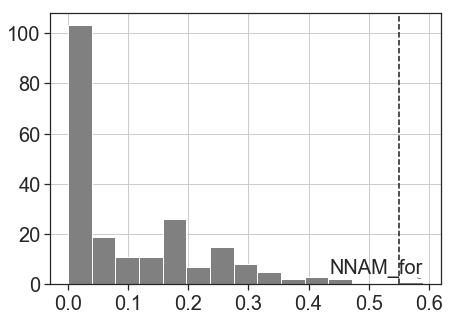

In [12]:
sns.set()
sns.set(style='ticks',font='Arial')

plot_objective_coefficients(
    obj_med_abs_df, "best_MNCs_med", ENSEMBLE_DIR, load_threshold=0.55, load_threshold_abs=True,
    pheno_id=pheno_id, sns_style="notebook", annotate_plt=True, savefig=True, verbose=True,
    bins=15, s_size=100, labelsizes=20, f_scale=1.0, figSIZE=(7,5)
)

Fuck that shit looks tight

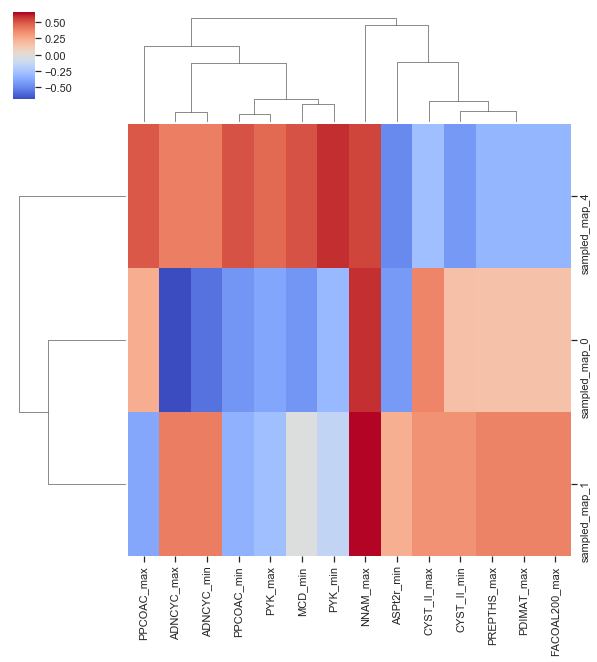

In [13]:
top_reacts = obj_med_abs_df[obj_med_abs_df>0.30].index.tolist()

sns.clustermap(obj_allsamples_df[top_reacts],cmap=cm.coolwarm)

# _OPTIONAL_ - Perform Bayesian Model Averaging of the MNC objectives using their weighted BIC values

In [14]:
obj_sample_fn = ENSEMBLE_DIR+"/tables/"+"obj_weighted_average__"+pheno_id+"__"+"BIC"+".csv"
obj_feature_weighted = pd.read_csv(obj_sample_fn,index_col=0)

df_top = obj_allsamples_df.copy()
top_mods = top_models.loc[df_top.index].copy()
top_mods.sort_values("BIC"+"_"+pheno_id, inplace=True)
sample_weight_ord = get_ic_weights(top_mods,pheno_id=pheno_id,ic_id="BIC").index.tolist()
sample_weight_vector = get_ic_weights(top_mods,pheno_id=pheno_id,ic_id="BIC").values
obj_allsamples_df_ord = df_top.loc[sample_weight_ord].copy()
obj_samples_weighted_avg = np.dot(abs(obj_allsamples_df_ord.T.fillna(0)), sample_weight_vector)
obj_samples_weighted_avg = np.dot(obj_allsamples_df_ord.T.fillna(0), sample_weight_vector) # .fillna(0)
obj_feature_weighted = pd.DataFrame(obj_samples_weighted_avg, 
                                    index=obj_allsamples_df_ord.columns, columns=["weighted_avg"])
obj_feature_weighted_ALL = obj_feature_weighted["weighted_avg"].sort_values(ascending=False)
# display(obj_feature_weighted_ALL)


df_top = obj_hqsamples_max_df.copy()
top_mods = top_models.loc[df_top.index].copy()
top_mods.sort_values("BIC"+"_"+pheno_id, inplace=True)
sample_weight_ord = get_ic_weights(top_mods,pheno_id=pheno_id,ic_id="BIC").index.tolist()
sample_weight_vector = get_ic_weights(top_mods,pheno_id=pheno_id,ic_id="BIC").values
obj_allsamples_df_ord = df_top.loc[sample_weight_ord].copy()
obj_samples_weighted_avg = np.dot(abs(obj_allsamples_df_ord.T.fillna(0)), sample_weight_vector)
# obj_samples_weighted_avg = np.dot(obj_allsamples_df_ord.T.fillna(0), sample_weight_vector) # .fillna(0)
obj_feature_weighted = pd.DataFrame(obj_samples_weighted_avg, 
                                    index=obj_allsamples_df_ord.columns, columns=["weighted_avg"])
obj_feature_weighted_MAX = obj_feature_weighted["weighted_avg"].sort_values(ascending=False)
# display(obj_feature_weighted_MAX)

FileNotFoundError: [Errno 2] File b'mnc_ensemble_0/tables/obj_weighted_average__pyrazinamide__BIC.csv' does not exist: b'mnc_ensemble_0/tables/obj_weighted_average__pyrazinamide__BIC.csv'

In [15]:
display(obj_feature_weighted_ALL)
display(obj_feature_weighted_MAX)

NameError: name 'obj_feature_weighted_ALL' is not defined

# `03b` - Analyze MNC flux states through Flux GWAS

1. Average the strain-specific flux states across the best MNCs and perform Flux GWAS

### 1. Identify and the median allele-specific constraint per allele in the best MNCs.
    - outputs: 
        - ENSEMBLE_DIR/allele_med_bnd-min_maptype-new_isoniazid.json
        - ENSEMBLE_DIR/allele_med_categoricalbnd-min_maptype-new_isoniazid.json
        
        
###  _OPTIONAL_: Perform the steps above except using the metabolite shadow prices.

In [18]:
med_or_mean='median'#"mean"#'median'
bic_thresh_val = 10
obj_direct_norm = True

for pheno_id in pheno_list:
    top_models = pd.read_csv(ENSEMBLE_DIR+"/tables/best_mncs_"+pheno_id+".csv",index_col=0)
    top_models = top_models[top_models - top_models.min() < bic_thresh_val].dropna()
    sample_list = top_models.index.tolist()
    print("Number of %s MNCs: %d"%(pheno_id, len(sample_list)))
    sig_flux_df, sol_dict = get_sig_feat_df(ENSEMBLE_DIR, pheno_id, sample_list, pheno_to_Y_dict,
                                            feat_type="pop_fluxes",med_or_mean=med_or_mean) # 'mean'
    sample_list = ["sample_"+x.split("_")[-1] for x in sample_list]
    popfva_longform_all_df = pd.DataFrame()
    flux_sol_all_df, sprice_sol_all_df, rcosts_sol_all_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    for sample_id in sample_list[:]:
        obj_direction, _ = get_mnc_direction(pheno_id, sample_id, ENSEMBLE_DIR)
        
        flux_sol_df = sol_dict[sample_id][pheno_id]["sol"]["pop_fluxes"].copy()
        sprice_sol_df = sol_dict[sample_id][pheno_id]["sol"]["pop_sprices"].copy()
        rcosts_sol_df = sol_dict[sample_id][pheno_id]["sol"]["pop_rcosts"].copy()
        if obj_direction=="min" and obj_direct_norm==True:
            flux_sol_df = 1 - flux_sol_df

        sampled_map_num = "sampled_map_"+str(sample_id.split("_")[1])
        flux_sol_df["index"] = flux_sol_df.index
        # flux_sol_df["sample_id"] = sampled_map_num
        flux_sol_df[pheno_id] = pheno_to_Y_dict[pheno_id]
        flux_sol_all_df = pd.concat([flux_sol_all_df, flux_sol_df],axis=0,ignore_index=True)

        sprice_sol_df["index"] = sprice_sol_df.index
        sprice_sol_df[pheno_id] = pheno_to_Y_dict[pheno_id]
        # sprice_sol_df["sample_id"] = sampled_map_num
        sprice_sol_all_df = pd.concat([sprice_sol_all_df, sprice_sol_df],axis=0,ignore_index=True)

        rcosts_sol_df["index"] = rcosts_sol_df.index
        rcosts_sol_df[pheno_id] = pheno_to_Y_dict[pheno_id]
        # rcosts_sol_df["sample_id"] = sampled_map_num
        rcosts_sol_all_df = pd.concat([rcosts_sol_all_df, rcosts_sol_df],axis=0,ignore_index=True)


    ### Average the fluxes per strain and perform MNC flux GWAS
    strain_flux_avg_df = flux_sol_df.copy()
    strain_flux_med_df = flux_sol_df.copy()
    for strain in tqdm(flux_sol_df.index.unique()[:]):
        strain_flux_avg_df.loc[strain]=flux_sol_all_df[(flux_sol_all_df["index"]==strain)].apply(lambda x: x.mean(), axis=0)
        strain_flux_med_df.loc[strain]=flux_sol_all_df[(flux_sol_all_df["index"]==strain)].apply(lambda x: x.median(), axis=0)

    strain_flux_avg_df["index"] = strain_flux_avg_df.index
    strain_flux_avg_df[pheno_id] = pheno_to_Y_dict[pheno_id]

    strain_flux_med_df["index"] = strain_flux_med_df.index
    strain_flux_med_df[pheno_id] = pheno_to_Y_dict[pheno_id]

    strain_flux_avg_df.to_csv(ENSEMBLE_DIR+"/tables/strain_flux_avg_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv")
    strain_flux_med_df.to_csv(ENSEMBLE_DIR+"/tables/strain_flux_med_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv")

    popdf_mean_flux_anova_df = get_flux_df_anova(strain_flux_avg_df.dropna(), pheno_id, sol_dict[sample_id][pheno_id]["anova"]["pop_fluxes"])
    popdf_median_flux_anova_df = get_flux_df_anova(strain_flux_med_df.dropna(), pheno_id, sol_dict[sample_id][pheno_id]["anova"]["pop_fluxes"])

    popdf_mean_flux_anova_df.to_csv(ENSEMBLE_DIR+"/tables/strain_flux_avg_ANOVA_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv")
    popdf_median_flux_anova_df.to_csv(ENSEMBLE_DIR+"/tables/strain_flux_med_ANOVA_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv")
    
    ### Average the metabolite shadow prices per strain and perform MNC flux GWAS
    strain_sprice_avg_df = sprice_sol_df.copy()
    strain_sprice_med_df = sprice_sol_df.copy()
    for strain in tqdm(sprice_sol_df.index.unique()[:]):
        strain_sprice_avg_df.loc[strain]=sprice_sol_all_df[(sprice_sol_all_df["index"]==strain)].apply(lambda x: x.mean(), axis=0)
        strain_sprice_med_df.loc[strain]=sprice_sol_all_df[(sprice_sol_all_df["index"]==strain)].apply(lambda x: x.median(), axis=0)

    strain_sprice_avg_df["index"] = strain_sprice_avg_df.index
    strain_sprice_avg_df[pheno_id] = pheno_to_Y_dict[pheno_id]

    strain_sprice_med_df["index"] = strain_sprice_med_df.index
    strain_sprice_med_df[pheno_id] = pheno_to_Y_dict[pheno_id]

    strain_sprice_avg_df.to_csv(ENSEMBLE_DIR+"/tables/strain_sprice_avg_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv")
    strain_sprice_med_df.to_csv(ENSEMBLE_DIR+"/tables/strain_sprice_med_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv")

    popdf_mean_sprice_anova_df = get_sprice_df_anova(strain_sprice_avg_df.dropna(), pheno_id, sol_dict[sample_id][pheno_id]["anova"]["pop_sprices"])
    popdf_median_sprice_anova_df = get_sprice_df_anova(strain_sprice_med_df.dropna(), pheno_id, sol_dict[sample_id][pheno_id]["anova"]["pop_sprices"])

    popdf_mean_sprice_anova_df.to_csv(ENSEMBLE_DIR+"/tables/strain_sprice_avg_ANOVA_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv")
    popdf_median_sprice_anova_df.to_csv(ENSEMBLE_DIR+"/tables/strain_sprice_med_ANOVA_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv")

  0%|          | 0/1 [00:00<?, ?it/s]

Number of isoniazid MNCs: 1


100%|██████████| 159/159 [01:43<00:00,  1.56it/s]
/Users/erolkavvas/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114 UserWarning: Features [   1    8   19   20   21   25   27   33   34   35   42   57   59   60
   68   69   71   76   90   91   95   99  100  101  103  105  116  117
  118  123  126  127  128  129  134  135  137  138  139  142  155  156
  183  185  191  194  195  196  197  198  201  202  203  206  207  208
  209  210  211  213  219  220  221  222  224  225  226  227  228  229
  230  233  234  235  236  242  245  246  247  248  249  252  253  254
  255  256  257  262  263  264  265  266  268  288  322  324  325  326
  328  333  338  339  357  361  362  364  379  386  401  402  403  404
  409  410  411  412  420  421  422  442  451  463  464  465  469  476
  478  479  495  503  538  539  540  541  543  563  565  566  568  572
  573  574  575  576  577  578  579  580  581  583  584  588  593  600
  601  605  616  617  619  620  621  

Number of rifampicin MNCs: 2


 78%|███████▊  | 124/159 [01:23<00:22,  1.52it/s]

KeyboardInterrupt: 

# Manhatten plots

Plot mean and median log10(p-value) for all reactions

In [19]:
pheno_id = "isoniazid"

In [20]:
popdf_mean_flux_anova_df = pd.read_csv(ENSEMBLE_DIR+"/tables/strain_flux_avg_ANOVA_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv",index_col=0)
popdf_median_flux_anova_df = pd.read_csv(ENSEMBLE_DIR+"/tables/strain_flux_med_ANOVA_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv",index_col=0)

# popdf_mean_flux_anova_df = pd.read_csv(ENSEMBLE_DIR+"/tables/strain_flux_avg_ANOVA_df_"+pheno_id+".csv",index_col=0)
# popdf_median_flux_anova_df = pd.read_csv(ENSEMBLE_DIR+"/tables/strain_flux_med_ANOVA_df_"+pheno_id+".csv",index_col=0)

In [21]:
popdf_median_flux_anova_df.head()

,F_value,pvalue,value_counts,subsystem,name,alleles_sim,genes,reaction
HSERTA,7.777497,0.005972,"[(1.0, 22), (0.44368409731784186, 6), (0.44368...",Cysteine and methionine metabolism,homoserine O-trans-acetylase,NaN,['Rv3341'],accoa_c + hom__L_c <=> achms_c + coa_c
ACHMSSH,7.777497,0.005972,"[(1.0, 22), (0.44368409731784186, 6), (0.44368...",Cysteine and methionine metabolism,NaN,NaN,['Rv3340'],achms_c + h2s_c --> ac_c + h_c + hcys__L_c
QRr,6.054725,0.014996,"[(0.9999999999999972, 86), (0.6853381195638514...",Oxidative Phosphorylation,QRr,NaN,['Rv3777'],h_c + nadph_c + q_c <=> nadp_c + qh2_c
CYO1a,6.054725,0.014996,"[(1.0, 106), (0.6853381195638533, 6), (0.68533...",Oxidative Phosphorylation,CYO1a,NaN,"['Rv2195', 'Rv2194', 'Rv2196']",2.0 ficytc_c + 2.0 h_c + qh2_c --> 2.0 focytc_...
FAS80_L,5.921505,0.016125,"[(0.9998141340030942, 46), (0.5350165737412274...",Fatty Acid Metabolism,Fatty acid synthase n C80 lumped reaction,['Rv1484'],"['Rv2524c', 'Rv2947c', 'Rv1484', 'Rv1350']",accoa_c + 8.0 h_c + 3.0 malcoa_c + 6.0 nadph_c...


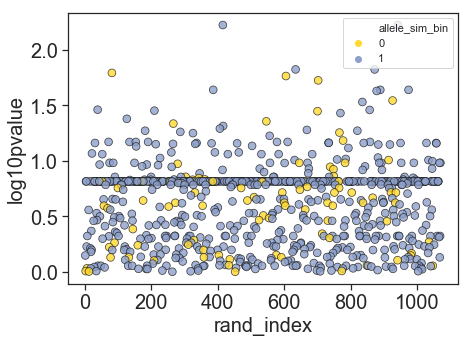

In [22]:
med_or_mean=='median'

if med_or_mean=='mean':
    X_df = popdf_mean_flux_anova_df.copy()
elif med_or_mean=='median':
    X_df = popdf_median_flux_anova_df.copy()
    
X_df.replace(0, X_df[X_df["pvalue"]>0.0]["pvalue"].min(), inplace=True)
X_df["log10pvalue"] = -np.log10(X_df["pvalue"])
X_df["allele_sim_bin"] = X_df["alleles_sim"].map(lambda x: 0 if isinstance(x, str) else 1)
fig, ax_manh_fluxes = plot_setup(row_num=1, col_num=1, s_size=100, labelsizes=20, f_scale=1.0, figSIZE=(7,5))
X_df, ax_manh_fluxes = plot_manhatten(X_df, "log10pvalue", hue="allele_sim_bin", palette="Set2_r",
                                      s_size=60, ax=ax_manh_fluxes, kwargs={"edgecolor":"k", "alpha":0.8})

Note! Be sure to specifiy a reasonable threshold such that few reactions are annotated on the plot.

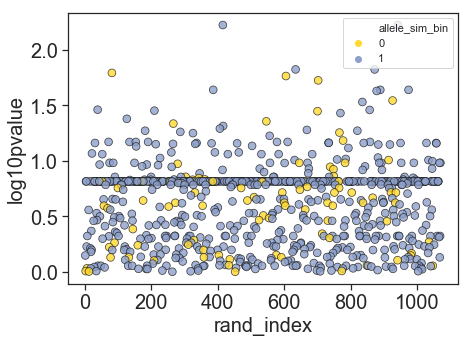

<Figure size 432x288 with 0 Axes>

In [23]:
thresh_annot = 40
save_fig=True
if med_or_mean=='mean':
    ax_manh_fluxes = annotate_plot(X_df, "log10pvalue", "rand_index", ax_manh_fluxes, 
                                   threshold=thresh_annot, fontsize=15)
    if save_fig==True:
        fig.savefig(ENSEMBLE_DIR+"/figures/hq_mean_flux_manhatten_"+pheno_id+".svg", format="svg")
        fig.savefig(ENSEMBLE_DIR+"/figures/hq_mean_flux_manhatten_"+pheno_id+".png", format="png")
        
elif med_or_mean=='median':
    ax_manh_fluxes = annotate_plot(X_df, "log10pvalue", "rand_index", ax_manh_fluxes, 
                                   threshold=thresh_annot, fontsize=15)
    if save_fig==True:
        fig.savefig(ENSEMBLE_DIR+"/figures/hq_median_flux_manhatten_"+pheno_id+".svg", format="svg")
        fig.savefig(ENSEMBLE_DIR+"/figures/hq_median_flux_manhatten_"+pheno_id+".png", format="png")
    
fig

### _Optional_ - plot manhatten plots for metabolites

In [24]:
popdf_mean_sprice_anova_df = pd.read_csv(ENSEMBLE_DIR+"/tables/strain_sprice_avg_ANOVA_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv",index_col=0)
popdf_median_sprice_anova_df = pd.read_csv(ENSEMBLE_DIR+"/tables/strain_sprice_med_ANOVA_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv",index_col=0)

# popdf_mean_sprice_anova_df = pd.read_csv(ENSEMBLE_DIR+"/tables/strain_sprice_avg_ANOVA_df_"+pheno_id+".csv",index_col=0)
# popdf_median_sprice_anova_df = pd.read_csv(ENSEMBLE_DIR+"/tables/strain_sprice_med_ANOVA_df_"+pheno_id+".csv",index_col=0)

No handles with labels found to put in legend.


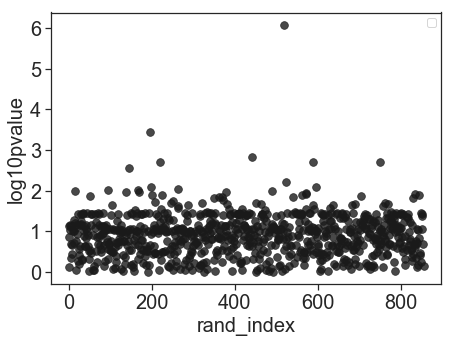

In [25]:
med_or_mean=='median'

if med_or_mean=='mean':
    X_df = popdf_mean_sprice_anova_df.copy()
elif med_or_mean=='median':
    X_df = popdf_median_sprice_anova_df.copy()
    
X_df.replace(0, X_df[X_df["pvalue"]>0.0]["pvalue"].min(), inplace=True)
X_df["log10pvalue"] = -np.log10(X_df["pvalue"])
fig, ax_manh_sprices = plot_setup(row_num=1, col_num=1, s_size=100, labelsizes=20, f_scale=1.0, figSIZE=(7,5))
X_df, ax_manh_sprices = plot_manhatten(X_df, "log10pvalue", hue=None, palette="Set2_r",
                                      s_size=60, ax=ax_manh_sprices, kwargs={"edgecolor":"k", "alpha":0.8})

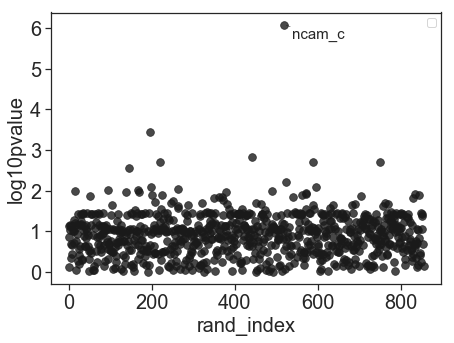

<Figure size 432x288 with 0 Axes>

In [26]:
thresh_annot = 5
save_fig=True
if med_or_mean=='mean':
    ax_manh_sprices = annotate_plot(X_df, "log10pvalue", "rand_index", ax_manh_sprices, 
                                   threshold=thresh_annot, fontsize=15)
    if save_fig==True:
        fig.savefig(ENSEMBLE_DIR+"/figures/hq_mean_sprice_manhatten_"+pheno_id+".svg", format="svg")
        fig.savefig(ENSEMBLE_DIR+"/figures/hq_mean_sprice_manhatten_"+pheno_id+".png", format="png")
        
elif med_or_mean=='median':
    ax_manh_sprices = annotate_plot(X_df, "log10pvalue", "rand_index", ax_manh_sprices, 
                                   threshold=thresh_annot, fontsize=15)
    if save_fig==True:
        fig.savefig(ENSEMBLE_DIR+"/figures/hq_median_sprice_manhatten_"+pheno_id+".svg", format="svg")
        fig.savefig(ENSEMBLE_DIR+"/figures/hq_median_sprice_manhatten_"+pheno_id+".png", format="png")
    
fig

# `03c` - Perform pathway enrichments using flux GWAS results

### 1. Load flux GWAS results and perform pathway richments using a curated pathway list
    - input: cobra_model/gene_to_pathways_filt.json
        get_kegg_pathways.ipynb was run before hand to get part of this list.
    - outputs: 
        - ENSEMBLE_DIR/allele_med_bnd-min_maptype-new_isoniazid.json
        - ENSEMBLE_DIR/allele_med_categoricalbnd-min_maptype-new_isoniazid.json
        
        
###  _OPTIONAL_: Perform the steps above except using the metabolite shadow prices.

In [28]:
# from mnc_utils import *

In [27]:
#gene_to_pathways = ens.load_json_obj("cobra_model/gene_to_pathways.json")
gene_to_pathways = ens.load_json_obj("cobra_model/gene_to_pathways_filt.json")

The code below is to be run for antibiotic.

In [31]:
all_subsys_phenos = pd.DataFrame()
SUBSYS_NUM_THRESHOLD = 2
add_small_pval = 1e-20
save_fig = False
kegg_or_biocyc = "biocyc"#"kegg" #"biocyc"#"kegg"
if kegg_or_biocyc=="kegg":
    g_to_pathways = kegg_gene_to_paths
elif kegg_or_biocyc=="biocyc":
    g_to_pathways = gene_to_pathways

###  "isoniazid", "pyrazinamide", "4-aminosalicylic_acid"
for pheno_id in ["isoniazid"]: # "4-aminosalicylic_acid"
    strain_flux_med_df=pd.read_csv(ENSEMBLE_DIR+"/tables/strain_flux_med_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv",index_col=0)
    strain_flux_avg_df=pd.read_csv(ENSEMBLE_DIR+"/tables/strain_flux_avg_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv",index_col=0)
    popdf_mean_flux_anova_df = pd.read_csv(ENSEMBLE_DIR+"/tables/strain_flux_avg_ANOVA_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv",index_col=0)
    popdf_median_flux_anova_df = pd.read_csv(ENSEMBLE_DIR+"/tables/strain_flux_med_ANOVA_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv",index_col=0)
    
    popdf_median_flux_anova_df_correct = correct_pvals(popdf_median_flux_anova_df,pval_col="pvalue", 
                                                   method="bonferroni", correct_alpha=0.05) # "fdr_bh"
    print(popdf_median_flux_anova_df_correct.shape)
    
    subsys_sig_median, react_to_subsys, subsys_to_sig_react = get_pathway_enrichments(ENSEMBLE_DIR,
        popdf_median_flux_anova_df, pheno_id, g_to_pathways,kegg_biocyc=kegg_or_biocyc, med_or_med="median",
        pval_thresh=popdf_median_flux_anova_df_correct["pvalue"].max()+add_small_pval,
        save_data=True
    )
    subsys_sig_median_filt = subsys_sig_median[subsys_sig_median["TOTAL_SUBSYS_NUM"]>SUBSYS_NUM_THRESHOLD]
    # all_subsys_phenos = pd.concat([all_subsys_phenos, subsys_sig_median_filt[["subsys_pval_"+pheno_id]]],axis=1)
    
subsys_sig_median_FDR = correct_pvals(subsys_sig_median_filt,pval_col="subsys_pval_"+pheno_id, method="fdr_bh", correct_alpha=0.05)
# subsys_sig_median_FDR = correct_pvals(subsys_sig_median_filt,pval_col="subsys_pval_"+pheno_id, method="fdr_bh", correct_alpha=0.05)
subsys_sig_median_FDR.to_csv(ENSEMBLE_DIR+"/tables/pathway_enriched_FDR_"+pheno_id+".csv")
subsys_sig_median_FDR = subsys_sig_median_FDR[subsys_sig_median_FDR["TOTAL_SUBSYS_NUM"]>SUBSYS_NUM_THRESHOLD]
subsys_sig_median_FDR = get_subsys_phenos_df(subsys_sig_median_FDR[["corrected_pVal"]], pval_drop=1, add_0pval=0, qval=False)

f, ax_subsys_enrich = plot_setup(row_num=1, col_num=1, s_size=100, labelsizes=20, f_scale=1.0, figSIZE=(3,len(subsys_sig_median_FDR.index)/2))
plot_subsys_enrich = -np.log10(subsys_sig_median_FDR["corrected_pVal"])
plot_subsys_enrich = plot_subsys_enrich[::-1]
plot_subsys_enrich.plot(kind="barh",ax=ax_subsys_enrich, color="slategrey")
if save_fig==True:
    f.savefig(ENSEMBLE_DIR+"/figures/subsys_enrich_barh_THRESH-"+str(SUBSYS_NUM_THRESHOLD)+"_"+kegg_or_biocyc+"_"+pheno_id+".png")
    f.savefig(ENSEMBLE_DIR+"/figures/subsys_enrich_barh_THRESH-"+str(SUBSYS_NUM_THRESHOLD)+"_"+kegg_or_biocyc+"_"+pheno_id+".svg")
print("# total subsystems: ",len(subsys_sig_median_filt.index))

(0, 9)
nan (0, 8)
	 0
	 0
	 0


/Users/erolkavvas/anaconda3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:147 RuntimeWarning: invalid value encountered in less_equal
/Users/erolkavvas/anaconda3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:251 RuntimeWarning: invalid value encountered in greater


ZeroDivisionError: division by zero

### Flux boxplots of significant reactions for each enriched pathway

In [ ]:
subsys_sig = subsys_sig_median_FDR
X_sig_df = popdf_median_flux_anova_df
flux_df = strain_flux_med_df.copy()# strain_flux_avg_df
med_or_mean = "median"

obj_direction_minmax = "min"#drug_to_minmax[pheno_id]
if obj_direction_minmax=="max": ## I.e., make all objectives minimization
    flux_df.iloc[:,:-2] = 1 - flux_df.iloc[:,:-2]

# plot_reacts = subsys_to_sig_react[subsys]
# plot_reacts = ["GCCb","MTHFD","GHMT2","GLYCL","MTHFR2","TMDS3" ,"TMDS","FOLR2", "DHFS","DHFR", "SHSL2r", "CYSTS","SERAT","SHSL1r", 
#                "CIGAMS","CYSTL","CYSS","SERD_L","CYST_II","PSERT","PSP_L","CYSK2_I","CYSM_I",
#               "HCYSMT","FOLD3","GLYt2r","GHMT2","biomass"]

# plot_reacts = ["MDH","CS", "KGD2", "FRD", "FRD2","FRD3", "ASPO5", "ARGSL", "ADSL1r", "ADSL2r","ADSS",
#               "SUCCt2r", "GLUDx"]
plot_reacts = X_sig_df.index.tolist()[:50]
name = "-".join(plot_reacts)
figsize=(len(plot_reacts)*1.2,2)
s_size=100
labelsizes=15
if len(plot_reacts)!=0:
    plot_flux_boxplot(ENSEMBLE_DIR, name, flux_df, plot_reacts, pheno_id, med_or_mean,
                      pre_y=True, whis=1.5, savefig=True,s_size=100,labelsizes=labelsizes,
                      notch=False, f_scale=1.0,figSIZE=figsize)

In [ ]:
popdf_mean_flux_anova_df.to_csv(ENSEMBLE_DIR+"/tables/strain_flux_avg_ANOVA_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv")
popdf_median_flux_anova_df.to_csv(ENSEMBLE_DIR+"/tables/strain_flux_med_ANOVA_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv")

# _OPTIONAL_: Conventional GWAS pathway enrichments

In [4]:
def get_pathway_allele_enrichments(allele_anova_df, pheno_id, gene_to_pathways, pval_thresh=0.05, save_data=True):
    allele_to_pathways = {}
    TOTAL_SUBSYSTEMS = []
    for allele, row in allele_anova_df[:].iterrows():
        allele_to_pathways[allele] = []
        allele_gene = allele.split("_")[0]
        if allele_gene in gene_to_pathways.keys():
            allele_to_pathways[allele].extend(gene_to_pathways[allele_gene])
        allele_to_pathways[allele] = list(set([x for x in allele_to_pathways[allele] if x!=""]))
        TOTAL_SUBSYSTEMS.extend(allele_to_pathways[allele])
        
    UNIQUE_SUBSYSTEMS = list(set(TOTAL_SUBSYSTEMS))
    
    X_df = allele_anova_df
    X_sig_df = allele_anova_df[allele_anova_df["pvalue"]<pval_thresh]
    SIG_SUBSYSTEMS = []
    for allele, row in X_sig_df[:].iterrows():
        SIG_SUBSYSTEMS.extend(allele_to_pathways[allele])
    
    print(pval_thresh, X_sig_df.shape)
    subsys_pval_dict = {}
    
    
    M_total = len(TOTAL_SUBSYSTEMS)
    for subsys_id in UNIQUE_SUBSYSTEMS:
        n_total = TOTAL_SUBSYSTEMS.count(subsys_id)
        k_ = SIG_SUBSYSTEMS.count(subsys_id)
        N_total = len(SIG_SUBSYSTEMS)
        sf_ = hypergeom.sf(k_, M_total, n_total, N_total)
        subsys_pval_dict.update({
            subsys_id: {"subsys_pval_"+pheno_id: sf_,
                        "SIG_SUBSYS_NUM": k_,
                        "TOTAL_SUBSYS_NUM": n_total
                                            }})
        
    subsys_sig = pd.DataFrame.from_dict(subsys_pval_dict,orient="index")
    subsys_sig.sort_values(["subsys_pval_"+pheno_id], inplace=True)
    
    subsys_sig_allele_dict = {}
    for subsys_id in list(set(SIG_SUBSYSTEMS)):
        subsys_sig_allele_dict[subsys_id] = []
        for allele_id, allele_subsystems in X_sig_df[:].iterrows():
            if subsys_id in allele_to_pathways[allele_id]:
                subsys_sig_allele_dict[subsys_id].append(allele_id)
    
    # subsys_sig.rename(mapper={x: x.replace("<i>", "").replace("</i>","") for x in subsys_sig.index},inplace=True)
    # subsys_sig.rename(mapper={x: x.replace("&", "").replace(";","") for x in subsys_sig.index},inplace=True)
    # subsys_sig.columns = ["subsys_pval_"+pheno_id]
    
    if save_data==True:
        subsys_sig.to_csv(ENSEMBLE_DIR+"/tables/allele_pathway_enrichments_"+pheno_id+".csv")
    return subsys_sig, allele_to_pathways, subsys_sig_allele_dict

In [ ]:
for pheno_id in ["isoniazid", "pyrazinamide", "4-aminosalicylic_acid"]:
    allele_ANOVA = pd.read_csv(ENSEMBLE_DIR+"/tables/anova_alleles_id_"+pheno_id+".csv",index_col=0)

    allele_ANOVA_correct = correct_pvals(
        allele_ANOVA,pval_col="pvalue", method="bonferroni", correct_alpha=0.05
    )
    print(allele_ANOVA_correct.shape)

    subsys_sig_allele_median, allele_to_pathways, pathway_to_alleles = get_pathway_allele_enrichments(
        allele_ANOVA, pheno_id, gene_to_pathways, pval_thresh=allele_ANOVA_correct["pvalue"].max()+1e-10, save_data=True
    )

    subsys_sig_median_FDR = correct_pvals(
        subsys_sig_allele_median,pval_col="subsys_pval_"+pheno_id, method="fdr_bh", correct_alpha=0.05
    )
    subsys_sig_median_FDR_correct = get_subsys_phenos_df(
        subsys_sig_median_FDR[["corrected_pVal"]], pval_drop=1, add_0pval=0, qval=False
    )
    subsys_sig_median_FDR_correct["alleles"] = subsys_sig_median_FDR.index.map(lambda x: pathway_to_alleles[x])
    subsys_sig_median_FDR.index = subsys_sig_median_FDR_correct.index
    subsys_sig_median_FDR["alleles"] = subsys_sig_median_FDR_correct["alleles"]

    subsys_sig_median_FDR.to_csv(ENSEMBLE_DIR+"/tables/allele_pathway_enriched_FDR_"+pheno_id+".csv")

subsys_sig_median_FDR

# Load tables and compile Supplementary materials

In [1]:
import pandas as pd
from mnc_utils import correct_pvals

In [2]:
ENSEMBLE_DIR = 'ens_strains375_alleles237_actions4'

# `Supplementary Files 2-4` - Isoniazid, Pyrazinamide, Para-aminosalicylic acid


Sheets
1. Objectives
    - sheets: antibiotics
    - rows: alleles  
    - cols: best MNCs  
    - first col: median constraint
2. Flux GWAS
3. Pathway enrichments
4. Allele-constraint map
    - rows: alleles  
    - cols: best MNCs  
    - first col: median constraint

In [9]:
def get_objective_sheet(ENSEMBLE_DIR, pheno_id):
    obj_hqsamples_abs_df = pd.read_csv(ENSEMBLE_DIR+"/tables/mnc_objectives_"+pheno_id+"__MAX-ABS"+".csv",index_col=0)
    obj_med_abs_df = pd.read_csv(ENSEMBLE_DIR+"/tables/mnc_objectives_"+pheno_id+"__med-abs"+".csv",index_col=0,header=None,squeeze=True)
    obj_med_abs_df.index.name = None
    obj_med_abs_df.name = "med-abs"
    obj_hqsamples_abs_df = obj_hqsamples_abs_df.T
    obj_df = pd.concat([obj_med_abs_df, obj_hqsamples_abs_df],axis=1)
    obj_df.sort_values(["med-abs"],ascending=False, inplace=True)
    return obj_df

In [10]:
bic_thresh_val = 10
obj_direct_norm = True

for pheno_id in ["isoniazid", "pyrazinamide", "4-aminosalicylic_acid"]:
    
    ### characters are too long for excel sheet so shorten to PAS
    if pheno_id == "4-aminosalicylic_acid":
        pheno_id_name = "PAS"
    else:
        pheno_id_name = pheno_id
            
    ### Sheet 1 - outline of other sheets
    outline_df = pd.DataFrame.from_dict({
        pheno_id_name+"_MNC_modelBIC": 'List of best MNCs with delta BIC < 10',
        pheno_id_name+"_MNC_objectives": 'Objective functions for best MNCs (absolute). First column is median absolute coefficient.',
        pheno_id_name+"_MNC_flux_GWAS": 'Univariate statistical tests between median strain-specific MNC reaction fluxes (minmax scaled) and AMR with Bonferroni-corrted p-value<0.05',
        pheno_id_name+"_MNC_shprice_GWAS": 'Univariate statistical tests between median strain-specific MNC metabolite shadow prices (minmax scaled) and AMR with Bonferroni-corrected p-value<0.05',
        pheno_id_name+"_MNC_pathway_enrich": 'Pathway enrichments of significant fluxes with FDR<0.05',
        pheno_id_name+"_MNC_allele_params": 'Pathway enrichments of significant fluxes with FDR<0.05. Ranked according to the ',
    },orient="index")
    outline_df.columns=["sheet description for "+pheno_id]

    with pd.ExcelWriter('Supplementary/Supplementary file '+pheno_id+'.xlsx') as writer:
        
        outline_df.to_excel(writer, sheet_name=pheno_id_name+" supp outline")
        
        top_models = pd.read_csv(ENSEMBLE_DIR+"/tables/best_mncs_"+pheno_id+".csv",index_col=0)
        top_models = top_models[top_models - top_models.min() < bic_thresh_val].dropna()
        top_models.to_excel(writer, sheet_name=pheno_id_name+"_MNC_modelBIC")
        
        objective_sheet = get_objective_sheet(ENSEMBLE_DIR, pheno_id)
        objective_sheet.to_excel(writer, sheet_name=pheno_id_name+"_MNC_objectives")
        
        flux_gwas_sheet = pd.read_csv(ENSEMBLE_DIR+"/tables/strain_flux_med_ANOVA_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv", index_col=0)
        flux_gwas_sheet_correct = correct_pvals(
            flux_gwas_sheet,pval_col="pvalue",method="bonferroni",correct_alpha=0.05
        )
        flux_gwas_sheet_correct.to_excel(writer, sheet_name=pheno_id_name+"_MNC_flux_GWAS")
        
        sprice_gwas_sheet = pd.read_csv(ENSEMBLE_DIR+"/tables/strain_sprice_med_ANOVA_df_"+pheno_id+"__objnorm-"+str(obj_direct_norm)+".csv",index_col=0)
        sprice_gwas_sheet_correct = correct_pvals(
            sprice_gwas_sheet,pval_col="pvalue",method="bonferroni",correct_alpha=0.05
        )
        sprice_gwas_sheet_correct.to_excel(writer, sheet_name=pheno_id_name+"_MNC_shprice_GWAS")
        
        pathway_enrich_sheet = pd.read_csv(ENSEMBLE_DIR+"/tables/pathway_enriched_FDR_"+pheno_id+".csv", index_col=0)
        pathway_enrich_sheet.to_excel(writer, sheet_name=pheno_id_name+"_MNC_pathway_enrich")

/Users/erolkavvas/anaconda3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:147 RuntimeWarning: invalid value encountered in less_equal
/Users/erolkavvas/anaconda3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:251 RuntimeWarning: invalid value encountered in greater
/Users/erolkavvas/anaconda3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:147 RuntimeWarning: invalid value encountered in less_equal
/Users/erolkavvas/anaconda3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:251 RuntimeWarning: invalid value encountered in greater
/Users/erolkavvas/anaconda3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:147 RuntimeWarning: invalid value encountered in less_equal
/Users/erolkavvas/anaconda3/lib/python3.7/site-packages/statsmodels/stats/multitest.py:251 RuntimeWarning: invalid value encountered in greater


# `Supplementary File 5` - Conventional GWAS analysis
Results regarding conventional GWAS analysis

In [ ]:
outline_df = pd.DataFrame.from_dict({
    'ANTIBIOTIC__ANOVA_bfr': 'Allele-ANTIBIOTIC associations with Bonferroni corrected P-value<0.05',
    'ANTIBIOTIC__pathways_fdr': 'Pathway-ANTIBIOTIC associations with FDR<0.05',
},orient="index")
outline_df.columns=["sheet description for isoniazid, pyrazinamide, and para-aminosalicylic acid (PAS)"]

with pd.ExcelWriter('Supplementary/Supplementary file 5.xlsx') as writer:
    outline_df.to_excel(writer, sheet_name="outline")
    for pheno_id in ["isoniazid","4-aminosalicylic_acid", "pyrazinamide"]:
        allele_ANOVA = pd.read_csv(ENSEMBLE_DIR+"/tables/anova_alleles_"+pheno_id+".csv", index_col=0)
        allele_ANOVA_id = pd.read_csv(ENSEMBLE_DIR+"/tables/anova_alleles_id_"+pheno_id+".csv", index_col=0)
        allele_ANOVA_bonferroni = pd.read_csv(ENSEMBLE_DIR+"/tables/anova_alleles_bonferroni-"+pheno_id+".csv", index_col=0)
        pathway_enriched = pd.read_csv(ENSEMBLE_DIR+"/tables/allele_pathway_enriched_FDR_"+pheno_id+".csv", index_col=0)
        if pheno_id == "4-aminosalicylic_acid":
            pheno_id = "PAS"
        allele_ANOVA_bonferroni.to_excel(writer, sheet_name=pheno_id+"__ANOVA_bfr")
        pathway_enriched.to_excel(writer, sheet_name=pheno_id+"__pathways_fdr")